# Code Comment Classification - Outliers Detection

This notebook performs the following Outliers Detection operations:
1. Load the encoded dataset
2. Outlier detection using isolation forest
3. Add outlier labels back to original data
4. Analyze results
5. Save outlier results
6. Visualization of outliers using PCA (2D)
7. Visualization of outliers using UMAP (2D)
8. Remove outliers
9. Save cleaned dataset

## 1. Load the encoded dataset

In [53]:
import pandas as pd
from scipy import sparse

# Load the encoded sparse matrix (.npz)
X_encoded = sparse.load_npz("encoded_features.npz")

# Load target column
y = pd.read_csv("target.csv")["category"]

print("Encoded feature matrix shape:", X_encoded.shape)
print("Target shape:", y.shape)


Encoded feature matrix shape: (2864, 8907)
Target shape: (2864,)


## 2. Outlier detection using isolation forest
`Isolation Forest` is chosen because:
- works well on high-dimensional sparse data
- scales well
- is unsupervised (no labels required)
- detects anomalies based on how isolated points appear

In [54]:
from sklearn.ensemble import IsolationForest

# Create the outlier detector
iso = IsolationForest(
    n_estimators=200,
    contamination="auto",  # automatically estimates outlier proportion
    random_state=42
)

# Fit the model on encoded features
iso.fit(X_encoded)

# Predict outliers:
#   +1 → normal point
#   -1 → outlier (anomaly)
outlier_labels = iso.predict(X_encoded)

# Convert to a convenient format:
#   1 → normal
#   0 → outlier
outliers_binary = (outlier_labels == -1).astype(int)

print("Outlier detection complete!")


Outlier detection complete!


## 3. Add outlier labels back to original data

In [55]:
# Load original dataset (before encoding)
df_original = pd.read_csv("code-comment-classification-encoded.csv")

# Add new column: 1 = outlier, 0 = normal
df_original["outlier"] = outliers_binary

df_original.head()


,comment_sentence_id,class,comment_sentence,category,outlier
0,512,MigrationGraph,migrations files can be marked as replacing an...,4,0
1,513,MigrationGraph,this is to support the squash feature.,4,0
2,514,MigrationGraph,the graph handler isn t responsible,4,0
3,515,MigrationGraph,"for these instead, the code to load them in he...",4,0
4,516,MigrationGraph,migration files and if the replaced migrations...,4,0


## 4. Analyze results

In [56]:
# Count outliers
num_outliers = df_original["outlier"].sum()
num_normal = len(df_original) - num_outliers

print(f"Total rows: {len(df_original)}")
print(f"Outliers detected: {num_outliers}")
print(f"Normal rows: {num_normal}")

# Show actual outlier rows
df_original[df_original["outlier"] == 1].head(10)


Total rows: 2864
Outliers detected: 0
Normal rows: 2864


,comment_sentence_id,class,comment_sentence,category,outlier


## 5. Save outlier results

In [57]:
# Save updated dataset with outlier labels
df_original.to_csv("code-comment-classification-with-outliers.csv", index=False)

# Save just the outlier predictions
pd.DataFrame({"outlier": outliers_binary}).to_csv("outlier-labels.csv", index=False)

print("Saved:")
print("- code-comment-classification-with-outliers.csv")
print("- outlier-labels.csv")


Saved:
- code-comment-classification-with-outliers.csv
- outlier-labels.csv


## 6. Visualization of outliers using PCA (2D)

PCA transformation complete. Explained variance: [0.02265474 0.02059516]


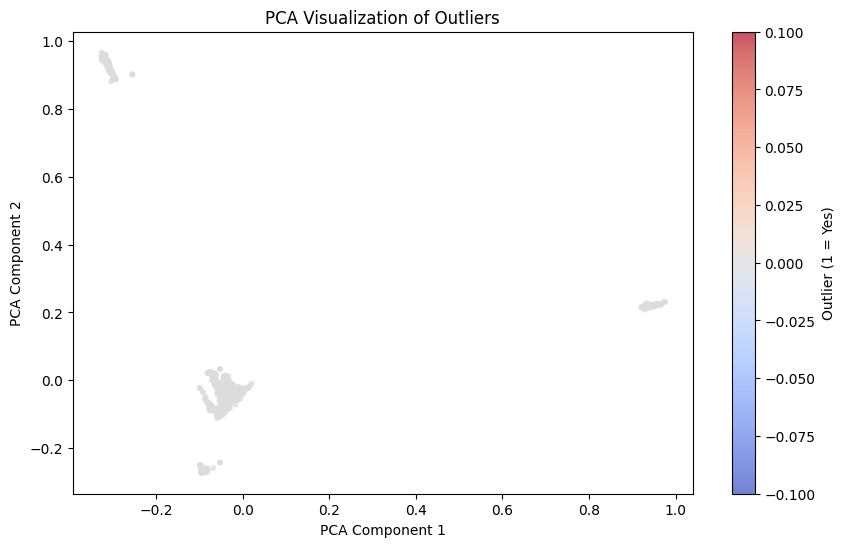

In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA works on dense arrays, so convert the sparse matrix (careful for large datasets)
X_dense = X_encoded.toarray()

# Reduce to 2 components for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

print("PCA transformation complete. Explained variance:",
      pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 6))

plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_original["outlier"],
    cmap="coolwarm",
    s=10,
    alpha=0.7
)

plt.title("PCA Visualization of Outliers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Outlier (1 = Yes)")
plt.show()


## 7. Visualization of outliers using UMAP (2D)
UMAP makes much more expressive 2-D embeddings than PCA for high-dimensional sp

c:\Users\lmacera\Desktop\CodeCommentClassification\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


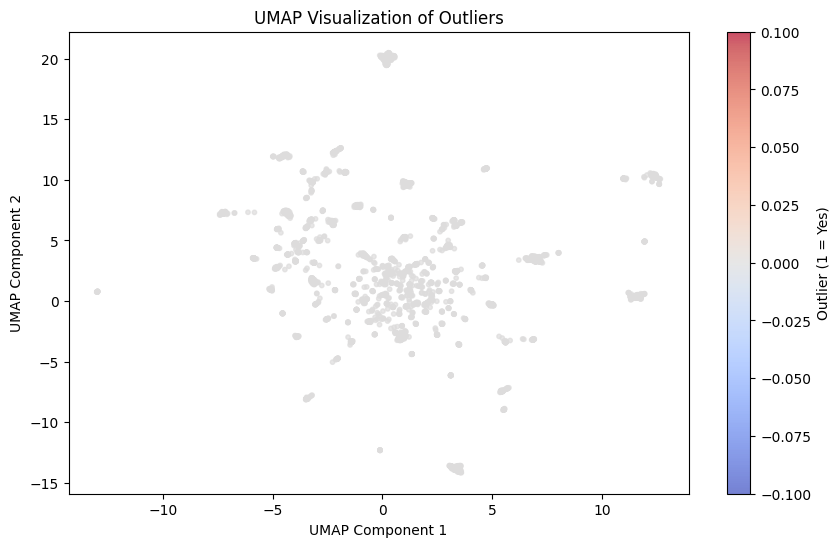

In [59]:
import umap

# Fit UMAP on the dense or sparse matrix (UMAP supports sparse input)
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_umap = umap_model.fit_transform(X_encoded)

# Plot
plt.figure(figsize=(10, 6))

plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=df_original["outlier"],
    cmap="coolwarm",
    s=10,
    alpha=0.7
)

plt.title("UMAP Visualization of Outliers")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(label="Outlier (1 = Yes)")
plt.show()


## 8. Remove outliers
We do not actually need to remove outliers since we have 0 outliers, but for clarity's sake we do the following steps anyway.
To remove the outliers we simply filter out rows where `"outlier" == 1`.

In [60]:
# Keep only normal points (outlier == 0)
df_clean = df_original[df_original["outlier"] == 0].reset_index(drop=True)

print("Original dataset size:", len(df_original))
print("Cleaned dataset size:", len(df_clean))
print("Rows removed:", len(df_original) - len(df_clean))

df_clean.head()

Original dataset size: 2864
Cleaned dataset size: 2864
Rows removed: 0


,comment_sentence_id,class,comment_sentence,category,outlier
0,512,MigrationGraph,migrations files can be marked as replacing an...,4,0
1,513,MigrationGraph,this is to support the squash feature.,4,0
2,514,MigrationGraph,the graph handler isn t responsible,4,0
3,515,MigrationGraph,"for these instead, the code to load them in he...",4,0
4,516,MigrationGraph,migration files and if the replaced migrations...,4,0


## 9. Save cleaned dataset

In [61]:
df_clean.to_csv("code-comment-classification-cleaned-no-outliers.csv", index=False)

print("Saved: code-comment-classification-cleaned-no-outliers.csv")


Saved: code-comment-classification-cleaned-no-outliers.csv
